In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ehtim as eh
from tqdm.notebook import tqdm
import functools

import jax
import flax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
from typing import Any, Callable
import optax
import sys
from flax.serialization import from_bytes
from flax.serialization import to_bytes

from datetime import datetime


Welcome to eht-imaging! v 1.2.10 



Loading text image:  datasets/avery_sgra_eofn.txt


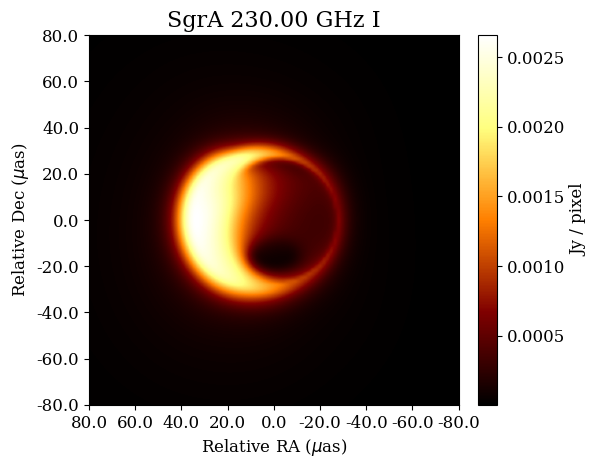

OBSERVED
Producing clean visibilities from image with nfft FT . . . 


In [2]:
image_path = 'datasets/avery_sgra_eofn.txt'
array_path = 'datasets/EHT2017.txt'
image_true = eh.image.load_txt(image_path)
array = eh.array.load_txt(array_path)
image_true.display()

tint = 5
tadv = 600
tstart_hr = 0
tstop_hr = 24

obs = array.obsdata(tint=tint, tadv=tadv, tstart=tstart_hr, tstop=tstop_hr, ra=image_true.ra, 
                    dec=image_true.dec, rf=image_true.rf, mjd=image_true.mjd,
                    bw=image_true.rf, timetype='UTC', polrep='stokes')
print("OBSERVED")

obs = image_true.observe_same_nonoise(obs) 

In [3]:
def shard(xs):
    """Split data into shards for multiple devices along the first dimension."""
    return jax.tree_util.tree_map(lambda x: x.reshape((jax.local_device_count(), -1) + x.shape[1:]), xs)

def flattened_traversal(fn):
    def mask(data):
        flat = flax.traverse_util.flatten_dict(data)
        return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
    return mask

class MLP(nn.Module): 
    net_depth: int = 4 
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu 
    out_channel: int = 1 
    do_skip: bool = True 
  
    @nn.compact 
    def __call__(self, x):
        """A simple Multi-Layer Preceptron (MLP) network

        Parameters
        ----------
        x: jnp.ndarray(float32), 
            [batch_size * n_samples, feature], points.
        net_depth: int, 
            the depth of the first part of MLP.
        net_width: int, 
            the width of the first part of MLP.
        activation: function, 
            the activation function used in the MLP.
        out_channel: 
            int, the number of alpha_channels.
        do_skip: boolean, 
            whether or not to use a skip connection

        Returns
        -------
        out: jnp.ndarray(float32), 
            [batch_size * n_samples, out_channel].
        """
        dense_layer = functools.partial(
            nn.Dense, kernel_init=jax.nn.initializers.he_uniform()) 

        if self.do_skip:
            skip_layer = self.net_depth // 2 


        inputs = x
        for i in range(self.net_depth): 
            x = dense_layer(self.net_width)(x) 
            x = self.activation(x) 
            if self.do_skip:
                if i % skip_layer == 0 and i > 0:
                    x = jnp.concatenate([x, inputs], axis=-1) 
        out = dense_layer(self.out_channel)(x) 

        return out


def posenc(x, deg):
    """
    Concatenate `x` with a positional encoding of `x` with degree `deg`.
    Instead of computing [sin(x), cos(x)], we use the trig identity
    cos(x) = sin(x + pi/2) and do one vectorized call to sin([x, x+pi/2]).

    Parameters
    ----------
    x: jnp.ndarray, 
        variables to be encoded. Note that x should be in [-pi, pi].
    deg: int, 
        the degree of the encoding.

    Returns
    -------
    encoded: jnp.ndarray, 
        encoded variables.
    """
    if deg == 0:
        return x
    scales = jnp.array([2**i for i in range(deg)]) 
    xb = jnp.reshape((x[..., None, :] * scales[:, None]),
                     list(x.shape[:-1]) + [-1]) 
    four_feat = safe_sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1))
    return jnp.concatenate([x] + [four_feat], axis=-1) 

class NeuralImage(nn.Module):
    """
    Full function to predict emission at a time step.
    
    Parameters
    ----------
    posenc_deg: int, default=3
    net_depth: int, default=4
    net_width: int, default=128
    activation: Callable[..., Any], default=nn.relu
    out_channel: int default=1
    do_skip: bool, default=True
    """
    posenc_deg: int = 3
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu
    out_channel: int = 1
    do_skip: bool = True
    
    @nn.compact
    def __call__(self, coords):
        image_MLP = MLP(self.net_depth, self.net_width, self.activation, self.out_channel, self.do_skip)
        def predict_image(coords):
            net_output = image_MLP(posenc(coords, self.posenc_deg))
            image = nn.sigmoid(net_output[..., 0] - 10.) 
            return image
        return predict_image(coords)
    
safe_sin = lambda x: jnp.sin(x % (100 * jnp.pi))

In [4]:
def loss_fn(params, predictor_fn, target, A, sigma, coords):
    '''
    Args:
        params: pytree (nested dict) of all of the model's weights and biases. 
        predictor_fn: the model's apply function
        target: measured intensities
        A: measurement matrix
        sigma: Thermal noise per visibility
        coords: array of shape (N_pixels, 2) with all (x,y) grid coords
    
    Returns:
        image: predicted intensities -> image
        loss: 
    '''
    image = predictor_fn({'params': params}, coords) # evanluate the neural image model at each (x, y)
    vis = jnp.matmul(A, image.ravel()) # return a view (no copy) if possible of image as a 1D array -> 
    loss = jnp.mean((jnp.abs(vis - target)/sigma)**2)
    return loss, [image]

@jax.jit
def train_step(state, target, A, sigma, coords):
    (loss, [image]), grads = jax.value_and_grad(loss_fn, argnums=(0), has_aux=True)(state.params, state.apply_fn, target, A, sigma, coords)
    grads = jax.lax.pmean(grads, axis_name='batch')
    state = state.apply_gradients(grads=grads)
    return loss, state, image

predictor = NeuralImage()
train_pstep = jax.pmap(train_step, axis_name='batch', in_axes=(0, 0, 0, 0, None))
print(jax.local_device_count())

4


In [6]:
"""
Run optimization. Note that this requieres tensorboard and tensorboardX for logging.
To remove tensorboard logging comment out the lines with # logging
"""

target = obs.data['vis']

npix = 100
fov = 1*image_true.fovx()
prior = eh.image.make_square(obs, npix, fov)
vis, sigma, A = eh.imaging.imager_utils.chisqdata_vis(obs, prior, mask=[])
x, y = np.linspace(0, 1, prior.xdim), np.linspace(0, 1, prior.ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)

hparams = {'num_iters': 20000, 'lr_init': 1e-3, 'lr_final': 1e-5, 'batchsize': 512}
params = predictor.init(jax.random.PRNGKey(1), coords)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params, tx=tx)  

state = flax.jax_utils.replicate(state)
for i in tqdm(range(hparams['num_iters']), desc='iteration'):
    batch = np.random.choice(range(len(target)), hparams['batchsize'], replace=False)
    loss, state, image = train_pstep(state, shard(target[batch, ...]), shard(A[batch, ...]), shard(sigma[batch, ...]), coords)
    # loss, state, image = train_step(state, target[batch, ...], A[batch, ...], sigma[batch, ...], coords)
    if i % 1000 == 0:
        print(loss)

state = jax.device_get(flax.jax_utils.unreplicate(state))


iteration:   0%|          | 0/20000 [00:00<?, ?it/s]

[2117938.5 1837963.8 2359454.5 1861301.6]
[6487.507 5073.431 4438.702 4516.982]
[ 6065.166 12408.621 12400.579 13908.713]
[469.7337  446.56113 428.71463 495.3888 ]
[377.70206 484.80518 496.15176 393.93564]
[321.53308 273.99597 290.3511  305.89948]
[284.68732 183.15295 302.36057 243.9852 ]
[165.686   183.64334 171.32224 180.65518]
[246.72469 290.3898  229.97864 264.13153]
[583.906   486.14435 488.00613 703.77527]
[118.30861  115.79996  110.031715 141.3709  ]
[121.80909 111.80842 115.92686  93.61236]
[102.18108   94.79122  107.71543   67.913284]
[90.15573  69.50104  64.885925 90.62047 ]
[70.46965  57.156464 72.65661  70.85353 ]
[47.824528 46.275276 54.274708 38.474915]
[38.094547 52.419838 38.014904 33.375282]
[30.957672 31.838243 30.51385  36.644516]
[32.38039  18.285793 25.722961 37.43266 ]
[14.842472 26.845009 23.119984 17.752712]


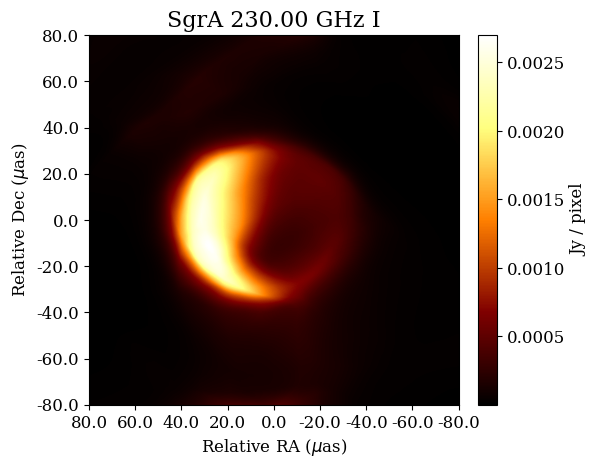

saved params to bh_vlbi_params.msgpack


In [ ]:
### training result
npix = 400
image_rec = eh.image.make_square(obs, npix, fov)
x, y = np.linspace(0, 1, image_rec.xdim), np.linspace(0, 1, image_rec.ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)
image_data = predictor.apply({'params': state.params}, coords)
image_rec.imvec = image_data.ravel()

image_rec.display()
s

In [ ]:
npix = 100
nvis = vis.shape[0]
print(nvis)
image_rec = eh.image.make_square(obs, npix, fov)
xdim = image_rec.xdim
ydim = image_rec.ydim
x, y = np.linspace(0, 1, xdim), np.linspace(0, 1, ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)

1030


In [ ]:
def bilinear(coords, theta):
    """gpt generated function to fill in for now"""
    gx, gy, _ = theta.shape
    # scale to vertex index space
    x = coords[..., 0] * (gx - 1)
    y = coords[..., 1] * (gy - 1)

    i0 = jnp.floor(x).astype(jnp.int32)
    j0 = jnp.floor(y).astype(jnp.int32)
    i1 = jnp.clip(i0 + 1, 0, gx - 1)
    j1 = jnp.clip(j0 + 1, 0, gy - 1)

    wx = x - i0
    wy = y - j0

    # gather four corners
    t00 = theta[i0, j0] # lower-left
    t10 = theta[i1, j0] # lower-right
    t01 = theta[i0, j1] # upper-left
    t11 = theta[i1, j1] # upper-right

    return ((1 - wx) * (1 - wy))[..., None] * t00 + \
           (wx * (1 - wy))[..., None] * t10 + \
           ((1 - wx) * wy)[..., None] * t01 + \
           (wx * wy)[..., None] * t11

class DeformationGrid(nn.Module):
    resolution: tuple[int, ...]

    @nn.compact
    def __call__(self, coords):
        theta = self.param(
            'theta', 
            nn.initializers.zeros, 
            self.resolution + (coords.shape[-1],)
        )
        return bilinear(coords, theta)

def forward_with_deform(params_img, params_def, coords, predictor_fn):
    offsets = DeformationGrid.apply({'params': params_def}, coords)
    image = predictor_fn.apply({'params': params_img}, coords + offsets)
    return jnp.matmul(A, image.ravel())

In [ ]:
def forward_visibility(params_def, coords):
    """
    add offset and get updated visibility matrix
    """
    offsets = def_grid.apply({'params': params_def}, coords)
    image = predictor.apply({'params': params_img_frozen}, coords + offsets)
    return jnp.matmul(A, image.ravel())

# compute derivatives of real and imaginary parts independently--otherwise H not differentiable
def re_vis(params_def, k):
    """Re(eps_theta(r))"""
    return jnp.real(forward_visibility(params_def, coords)[k])

def im_vis(params_def, k):
    """Im(eps_theta(r))"""
    return jnp.imag(forward_visibility(params_def, coords)[k])

#take the gradient of a forward_visibility (real or imaginary) over k visibilities
def flatten(tree):
    return jnp.concatenate([t.ravel() for t in jax.tree_util.tree_leaves(tree)])

def grad_row(fn, k):
    g_tree = jax.grad(fn)(params_def, k)
    return flatten(g_tree['theta'])

# compute hessian in chunks
@functools.partial(jax.jit, static_argnums=(1,))
def chunk(idx, fn, sigma_batch):
    J = jax.vmap(lambda k: grad_row(fn, k))(idx) # evaluate grad_row over each i \in idx
    J = J.reshape((J.shape[0], -1))
    J = J / (sigma_batch[:, None] / jnp.sqrt(2))
    return J.T @ J

def fisher_sum(chunk_size, P, nvis):
    """
    Can no longer assume sigma^2 = 1/2 or use abs in loss fn. Take the derivative of the real and imaginary parts
    and compute in chunks of rows to avoid OOM. 
    
    Args:
        chunk_size: number of rows of the jacobian to evaluate in one step
        res: grid resolution, (xdim, ydim); 2D for now
    Returns:
        J_sq: = sum( (J_re_n^2 + J_im_n^2) / sigma_n^2)
    """
    #J_sq = jnp.zeros((res[0], res[1], 2))
    H = jnp.zeros((P, P))
    for start in tqdm(range(0, nvis, chunk_size), desc='iteration'):
        end = min(start+chunk_size, nvis)
        idx = jnp.arange(start, end)
        H += chunk(idx, re_vis, sigma[idx])+chunk(idx, im_vis, sigma[idx])
    return H

@functools.partial(jax.jit, static_argnums=(1,))
def chunk_diag(idx, fn, sigma_batch):
    J = jax.vmap(lambda k: grad_row(fn, k))(idx)
    J = J.reshape((J.shape[0], -1))
    J = J / (sigma_batch[:, None] / jnp.sqrt(2))
    return jnp.sum(J**2, axis=0)

def fisher_sum_diag(chunk_size, P, nvis):
    """
    Can no longer assume sigma^2 = 1/2 or use abs in loss fn. Take the derivative of the real and imaginary parts
    and compute in chunks of rows to avoid OOM. 
    
    Args:
        chunk_size: number of rows of the jacobian to evaluate in one step
        res: grid resolution, (xdim, ydim); 2D for now
    Returns:
        J_sq: = sum( (J_re_n^2 + J_im_n^2) / sigma_n^2)
    """
    #J_sq = jnp.zeros((res[0], res[1], 2))
    H = jnp.zeros((P,))
    for start in tqdm(range(0, nvis, chunk_size), desc='iteration'):
        end = min(start+chunk_size, nvis)
        idx = jnp.arange(start, end)
        H += chunk_diag(idx, re_vis, sigma[idx])+chunk_diag(idx, im_vis, sigma[idx])
    return H


@functools.partial(jax.jit, static_argnums=(1,2))
def _grad_block(idx, fn, chunk):
    @jax.checkpoint
    def one(k):
        g = jax.grad(lambda p: fn(p, k))(params_def)
        return flatten(g['theta'])
    return jax.vmap(one)(idx)

def build_J_scaled(params_def, nvis, sigma, block=32):
    pieces = []
    for start in range(0, nvis, block):
        idx = jnp.arange(start, min(start+block, nvis))
        pieces.append(_grad_block(idx, re_vis, block))
    for start in range(0, nvis, block):
        idx = jnp.arange(start, min(start+block, nvis))
        pieces.append(_grad_block(idx, im_vis, block))
    Js = jnp.concatenate(pieces, axis=0)           # (2N,P)
    sigma_big = jnp.concatenate([sigma, sigma], 0)
    return Js / (sigma_big[:, None] / jnp.sqrt(2))


def woodbury_diag(Js, lam):
    """
    Diagonal of H^{-1} using the Woodbury identity
    Js : (2N, P)   row‑scaled Jacobian
    lam: scalar    same λ that multiplies the ridge term 2λ I
    """
    lam2 = 2.0 * lam
    a_inv = 1.0 / lam2

    JJt = Js @ Js.T
    B = jnp.eye(JJt.shape[0]) + (1/lam2) * JJt
    B_inv = jnp.linalg.inv(B)

    diag_term = jnp.sum(Js * (B_inv @ Js), axis=0)
    V_diag = a_inv - (a_inv**2) * diag_term
    return V_diag


def compute_hessian_and_uncertainty(chunk_size: int, P, lam: float, method: str):
    '''
    Args:
        chunk_size (int): how many rows of the hessian to compute at a time. This is deterministic
        not approximated
        lam (float): laplace regularizer
        method (str): 
            'approx': bayes rays' implementation, never build full hessian
            'direct': build full hessian, invert, keep only diagonal of covariance matrix
            '': build full hessian, invert, keep full covariance matrix
    Returns:
        (jnp.ndarray shape (P, P), jnp.ndarray shape(nvis, nvis))
    '''
    
    if method == "approx":
        H = fisher_sum_diag(chunk_size, P, nvis)
        #lam = 0.5*0.02*jnp.median(H)
        #print('lambda:', lam)
        H = H + 2*lam
        V = 1/H
    elif method == "woodbury":

        Js = build_J_scaled(params_def, nvis, sigma)
        f_diag = jnp.sum(Js**2, axis=0)
        lam = 0.5*0.02*jnp.median(f_diag)
        print('lambda:', lam)
        V_diag = woodbury_diag(Js, lam)
        return None, V_diag
    else:
        H = fisher_sum(chunk_size, P, nvis)
        lam = 0.5*0.02*jnp.median(jnp.diag(H))
        print('lambda:', lam)
        H = H + 2.0*lam*jnp.eye(P)
        
        V = jnp.linalg.inv(H)
        if method == "direct":
            V = jnp.diag(V)
    return H, V

In [ ]:
grid_res = (64, 64)
P = 2 * grid_res[0] * grid_res[1] #the number of parameters in the grid
def_grid = DeformationGrid(grid_res)

# freeze parameters 
params_img = state.params
params_img_frozen = jax.tree_util.tree_map(jnp.array, params_img)

params_def = def_grid.init(
    jax.random.PRNGKey(0), 
    jnp.array([[0, 0]]))['params']
params_def = jax.tree_util.tree_map(jnp.zeros_like, params_def)

_, sigma, _ = eh.imaging.imager_utils.chisqdata_vis(obs, prior, mask=[])

lam = 3e4
diagonal = "direct"
H, V = compute_hessian_and_uncertainty(chunk_size=10, P=P, lam=lam, method=diagonal)

iteration:   0%|          | 0/103 [00:00<?, ?it/s]

lambda: 51.24336


In [ ]:
gx, gy = grid_res
def flat_idx(i, j, channel): # channel=0(x) or 1(y)
    return 2 * (i*gy + j) + channel

@jax.jit
def build_W_and_idx(u):
    """
    Build the bilinear weight matrix and neighboring weight indicies for effective batching so we dont OOM
    Note that the batching is deterministic. 
    """
    ux, uy = u
    x = ux * (gx-1)
    y = uy * (gy-1)
    i0, j0 = jnp.floor(x).astype(int), jnp.floor(y).astype(int)
    i1, j1 = jnp.minimum(i0+1, gx-1), jnp.minimum(j0+1, gy-1)
    wx, wy = x - i0, y - j0

    # four vertex weights
    w  = jnp.array([
        (1-wx)*(1-wy),
        wx *(1-wy),
        (1-wx)*wy,
        wx *wy,
    ])
    idx = jnp.array([
        flat_idx(i0,j0,0), flat_idx(i0,j0,1),
        flat_idx(i1,j0,0), flat_idx(i1,j0,1),
        flat_idx(i0,j1,0), flat_idx(i0,j1,1),
        flat_idx(i1,j1,0), flat_idx(i1,j1,1),
    ]) # length-8

    #sigma_sub = V[idx[:,None], idx[None,:]]  # (8,8) sub matrix of neighboring bilinear interpolation weights
    W = jnp.stack([ # 2×8
        jnp.reshape(jnp.repeat(w,2)[0::2], (4,)), # x-weights
        jnp.reshape(jnp.repeat(w,2)[1::2], (4,)), # y-weights
    ], axis=0).repeat(2, axis=1)[:,:8]
    
    return idx, W
    '''C = W @ sigma_sub @ W.T
    return jnp.sqrt(jnp.trace(C))'''

def make_unc_fn(Sigma):
    """
    Function to handle both a diagonal and full hessian computation.
    Later, we compare the diagonal with the full hessian.
    """
    is_diag = Sigma.ndim==1

    @jax.jit
    def pixel_sigma(u):
        idx, W = build_W_and_idx(u)
        if is_diag:
            sigma_sub = jnp.diag(Sigma[idx])
        else:
            sigma_sub = Sigma[idx[:,None], idx[None,:]]
        return jnp.sqrt(jnp.trace(W @ sigma_sub @ W.T))
    return pixel_sigma

# vectorise over pixels in manageable chunks
def sigma_map_from_coords(coords, Sigma, chunk=8192):
    """
    compute the full uncertainty map from bayes rays, evaluating at 
    each point in coords
    """
    c_flat = coords.reshape(-1,2)
    unc_fn = make_unc_fn(Sigma)
    out = []
    for k in range(0, c_flat.shape[0], chunk):
        out.append(jax.vmap(unc_fn)(c_flat[k:k+chunk]))
    return jnp.concatenate(out).reshape(coords.shape[:2])

def vis_to_image(vis_vec, n_crop, full_N=xdim):
    """to visualize the magnitude of noise added (note it was added in fourier space)"""
    uv = np.zeros((full_N, full_N), dtype=np.complex64)
    cx = (full_N - n_crop) // 2
    cy = (full_N - n_crop) // 2
    uv[cy:cy+n_crop, cx:cx+n_crop] = vis_vec.reshape(n_crop, n_crop)
    return np.fft.ifft2(np.fft.ifftshift(uv)).real

def plot_uncertainty_figs(sigma_map, log_scaled: bool, save_fig: bool, parent_dir: str):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    if log_scaled:
        im1 = ax1.imshow(jnp.log10(sigma_map.T + 1e-12), cmap='plasma', origin="upper")
        ax1.set_title(f"Uncertainty map (log scaled)\ngrid res={grid_res}, diagonal={'None' if not diagonal else diagonal}")
    else: 
        p98 = jnp.percentile(sigma_map, 98)
        p2 = jnp.percentile(sigma_map, 2)
        im1 = ax1.imshow(sigma_map.T, vmin=p2, vmax=p98, cmap='plasma', origin="upper")
        ax1.set_title(f"Uncertainty map (2th-98th percentile)\ngrid res={grid_res}\n, diagonal={'None' if not diagonal else diagonal}")
    
    npix = 400
    image_rec = eh.image.make_square(obs, npix, fov)
    x, y = np.linspace(0, 1, image_rec.xdim), np.linspace(0, 1, image_rec.ydim)
    coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)
    image_data = predictor.apply({'params': state.params}, coords)
    image_rec.imvec = image_data.ravel()
    
    image_rec.display(axis=ax2)
    ax2.set_title('Ground truth')

    fig.colorbar(im1, ax=ax1, pad=0.04)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{parent_dir}/grid_res{grid_res[0]}x{grid_res[1]}_diagonal{diagonal}.png')
    plt.show()
    return sigma_map


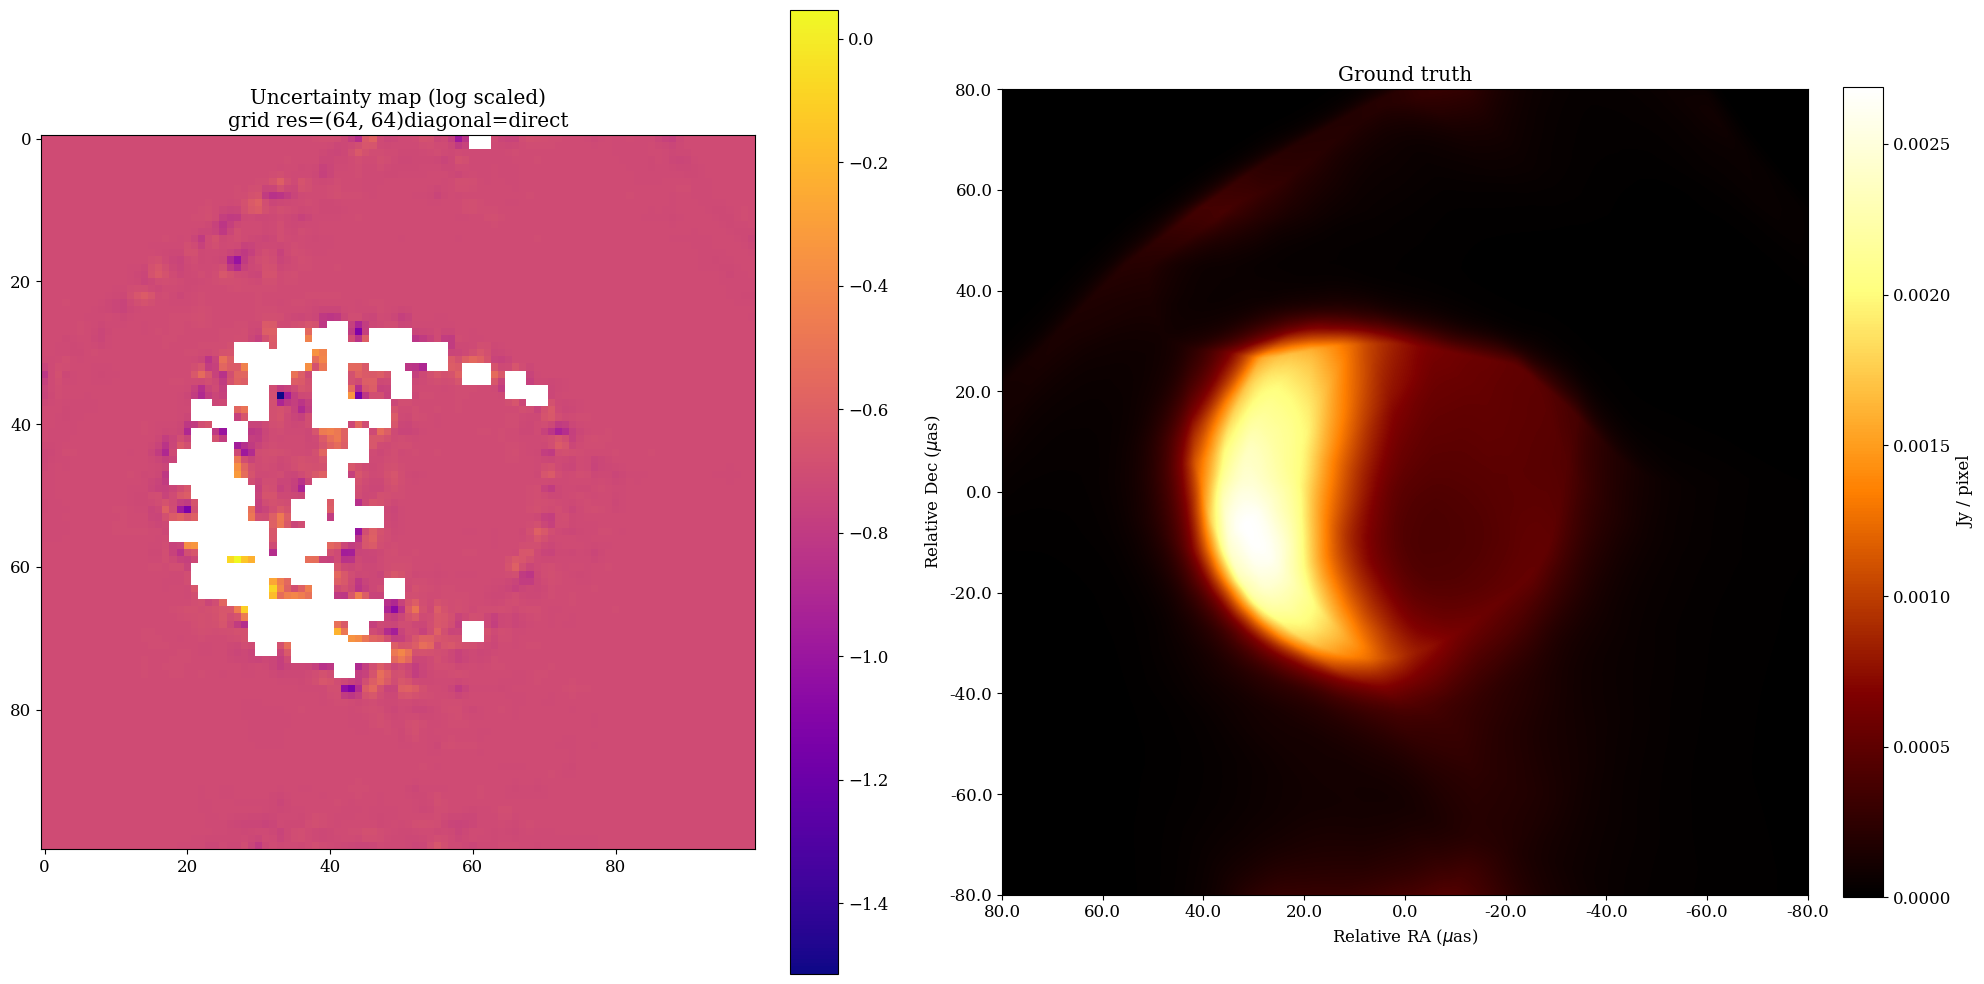

In [ ]:
# bilinear upsample
grid_coords = np.stack(np.meshgrid(np.linspace(0, 1, gx), np.linspace(0, 1, gy), indexing='xy'), axis=-1)
sigma_map = sigma_map_from_coords(grid_coords, V).reshape(gx, gy)
sigma_map = bilinear(coords, sigma_map[..., None]).squeeze(-1)

plot_uncertainty_figs(sigma_map, True, True, parent_dir='bh_vlbi_unc_results')
print()

In [ ]:
print(float(sigma.min()), float(sigma.max()))
print(H.shape)
F_diag = H - (2*jnp.mean(H)*0.01)
print(np.count_nonzero(F_diag>1e-12))
print(np.count_nonzero(F_diag<1e-12))
print(jnp.median(H))
print(jnp.mean(H))
print("mean fisher", float(F_diag.mean()), "prior:", 2*jnp.mean(H)*0.01)

0.0002659736923655093 0.0082653835275846


AttributeError: 'NoneType' object has no attribute 'shape'